## Data Context

Run: The run number of the event.<br>
Event: The event number.<br>
E1, E2: The total energy of the electron (GeV) for electrons 1 and 2.<br>
px1,py1,pz1,px2,py2,pz2: The components of the momemtum of the electron 1 and 2 (GeV).<br>
pt1, pt2: The transverse momentum of the electron 1 and 2 (GeV).<br>
eta1, eta2: The pseudorapidity of the electron 1 and 2.<br>
phi1, phi2: The phi angle of the electron 1 and 2 (rad).<br>
Q1, Q2: The charge of the electron 1 and 2.<br>
M: The invariant mass of two electrons (GeV).

Need to predict invariant mass and explain the model.

Data link: https://www.kaggle.com/datasets/fedesoriano/cern-electron-collision-data/data

## Data Loading and Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import scipy.stats as stats
import shap

GLOBAL_SEED = 69
rng = np.random.default_rng(GLOBAL_SEED)
shap.plots.initjs()

c:\Users\User\Documents\Others\Random projects\random_stuffs\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the dataset
df = pd.read_csv('data/dielectron.csv')

# Display the shape of the data and the head
print(df.shape)
df.head()

(100000, 19)


,Run,Event,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,E2,px2,py2,pz2,pt2,eta2,phi2,Q2,M
0,147115,366639895,58.71410,-7.31132,10.531000,-57.29740,12.82020,-2.20267,2.17766,1,11.2836,-1.032340,-1.88066,-11.0778,2.14537,-2.344030,-2.072810,-1,8.94841
1,147115,366704169,6.61188,-4.15213,-0.579855,-5.11278,4.19242,-1.02842,-3.00284,-1,17.1492,-11.713500,5.04474,11.4647,12.75360,0.808077,2.734920,1,15.89300
2,147115,367112316,25.54190,-11.48090,2.041680,22.72460,11.66100,1.42048,2.96560,1,15.8203,-1.472800,2.25895,-15.5888,2.69667,-2.455080,2.148570,1,38.38770
3,147115,366952149,65.39590,7.51214,11.887100,63.86620,14.06190,2.21838,1.00721,1,25.1273,4.087860,2.59641,24.6563,4.84272,2.330210,0.565865,-1,3.72862
4,147115,366523212,61.45040,2.95284,-14.622700,-59.61210,14.91790,-2.09375,-1.37154,-1,13.8871,-0.277757,-2.42560,-13.6708,2.44145,-2.423700,-1.684810,-1,2.74718


In [3]:
# Display column info and number of missing values
print("Column Info:\n")
print(df.info())

print("Missing Values:\n")
print(df.isna().sum())

Column Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 19 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Run     100000 non-null  int64  
 1   Event   100000 non-null  int64  
 2   E1      100000 non-null  float64
 3   px1     100000 non-null  float64
 4   py1     100000 non-null  float64
 5   pz1     100000 non-null  float64
 6   pt1     100000 non-null  float64
 7   eta1    100000 non-null  float64
 8   phi1    100000 non-null  float64
 9   Q1      100000 non-null  int64  
 10  E2      100000 non-null  float64
 11  px2     100000 non-null  float64
 12  py2     100000 non-null  float64
 13  pz2     100000 non-null  float64
 14  pt2     100000 non-null  float64
 15  eta2    100000 non-null  float64
 16  phi2    100000 non-null  float64
 17  Q2      100000 non-null  int64  
 18  M       99915 non-null   float64
dtypes: float64(15), int64(4)
memory usage: 14.5 MB
None
Missing Values:

Run 

There are 100000 data points and 85 of them has missing M value. As the amount of missing value is very low, they are discarded here.

In [4]:
# Data cleaning
original_length = len(df)

df = df.dropna(subset=['M'])

print(f"Removed {original_length - len(df)} null data points")
print(f"Current number of events: {len(df)}")

Removed 85 null data points
Current number of events: 99915


In [5]:
# Check and remove duplicate rows
original_length = len(df)

print(f"Number of duplicate rows: {df.duplicated().sum()}")

df = df.drop_duplicates()

print(f"Removed {original_length - len(df)} duplicate data points")
print(f"Current number of events: {len(df)}")

Number of duplicate rows: 23
Removed 23 duplicate data points
Current number of events: 99892


In [6]:
# Show the statistical summary of the dataset
df.describe()

,Run,Event,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,E2,px2,py2,pz2,pt2,eta2,phi2,Q2,M
count,99892.000000,9.989200e+04,99892.000000,99892.000000,99892.000000,99892.000000,99892.000000,99892.000000,99892.000000,99892.000000,99892.000000,99892.000000,99892.000000,99892.000000,99892.000000,99892.000000,99892.000000,99892.000000,99892.000000
mean,147935.537871,4.957532e+08,36.459695,0.136384,0.183445,-1.512384,14.417882,-0.064220,0.021958,-0.005466,44.030701,-0.002902,0.125600,-1.590087,13.805510,-0.072900,0.021667,-0.004265,30.020882
std,920.341884,4.038182e+08,41.223335,13.408913,13.475059,51.623350,12.391571,1.462644,1.799509,0.999990,46.763373,13.130931,13.172812,61.457682,12.464594,1.738682,1.816894,0.999996,25.255932
min,146511.000000,6.414000e+03,0.377928,-250.587000,-126.079000,-840.987000,0.219629,-4.165380,-3.141580,-1.000000,0.472500,-233.730000,-145.651000,-655.396000,0.026651,-7.064790,-3.141580,-1.000000,2.000080
25%,147114.000000,2.023211e+08,8.471438,-5.236865,-5.282197,-15.899575,3.773227,-1.284752,-1.526615,-1.000000,11.069550,-4.793865,-4.605640,-22.062375,3.738480,-1.893003,-1.556020,-1.000000,12.445850
50%,147929.000000,3.902596e+08,21.740300,0.141563,0.100481,-0.313852,12.972400,-0.061568,0.035074,-1.000000,25.292400,-0.035024,0.084412,-0.694057,11.692300,-0.136785,0.027410,-1.000000,21.284100
75%,149011.000000,6.340891e+08,50.063975,5.719105,5.652223,13.231550,20.026275,1.145393,1.562642,1.000000,66.984775,4.819960,5.063548,19.045400,19.602000,1.769330,1.596837,1.000000,39.028550
max,149182.000000,1.791247e+09,850.602000,134.539000,147.467000,760.096000,265.578000,2.622970,3.141420,1.000000,948.375000,227.330000,166.283000,935.558000,281.654000,3.060550,3.141290,1.000000,109.999000


Doesn't seem like there is any negative value for energy (E1, E2) or mass (M). So no need to clear data further.

### Visualization of the data

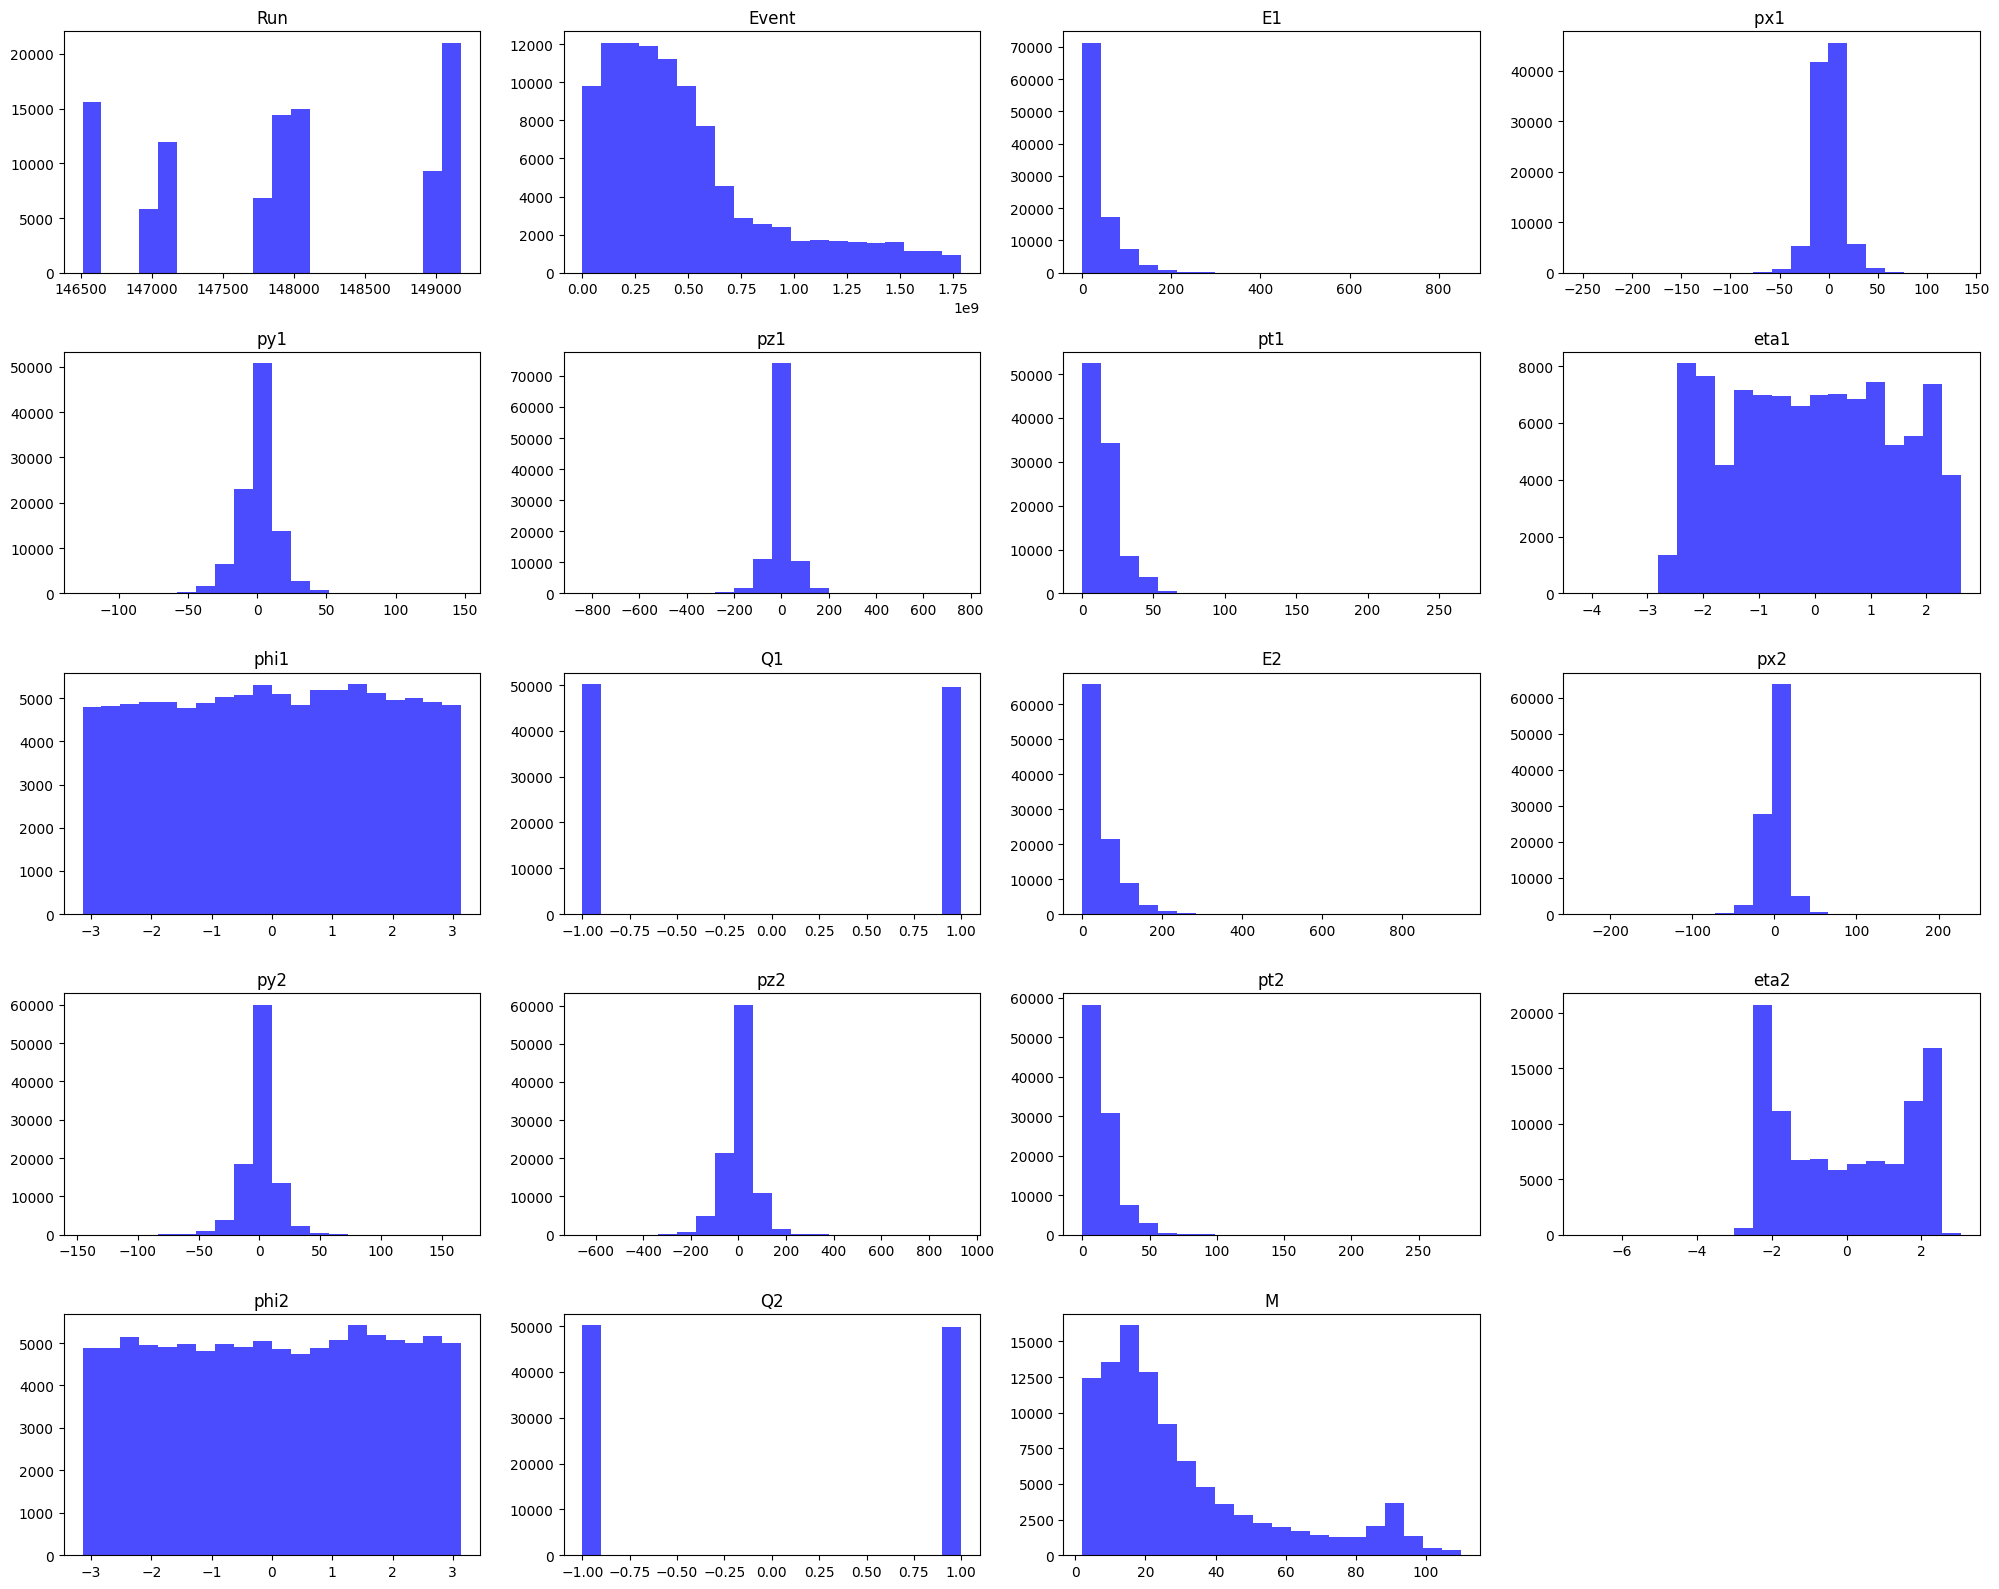

In [7]:
# Show 19 histograms in a 5x4 grid
fig, axs = plt.subplots(5, 4, figsize=(20, 16))
plot_idx = 0
for column in df.columns:
    ax = axs[plot_idx // 4, plot_idx % 4]
    ax.hist(df[column].dropna(), bins=20, color='blue', alpha=0.7)
    ax.set_title(column)
    plot_idx += 1

# Hide the unused last subplot
axs[4, 3].axis('off')

plt.tight_layout()
plt.show()

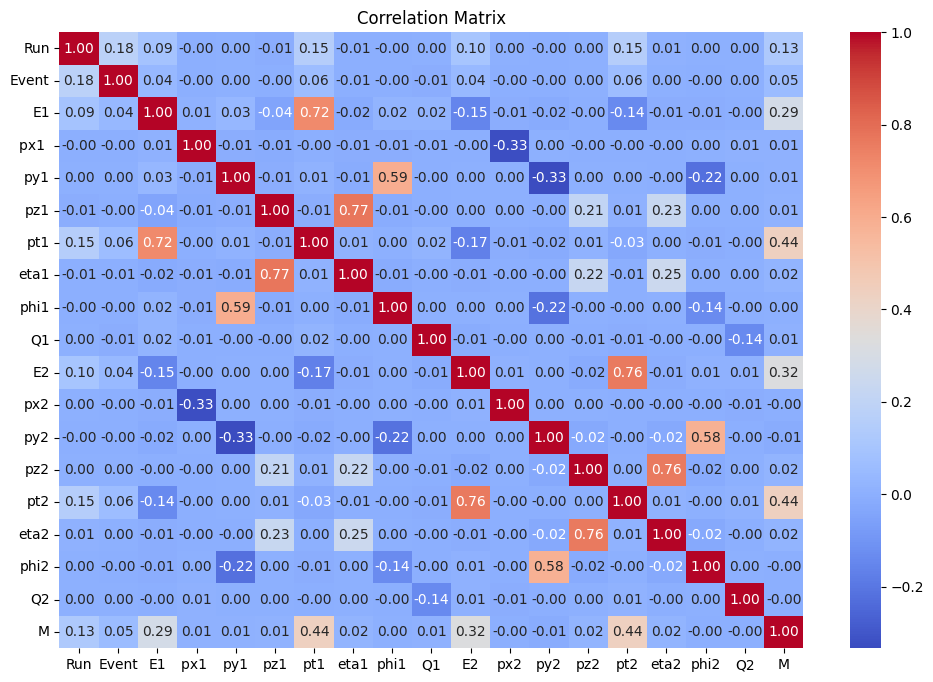

In [8]:
# Show correlation heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()

## Data Splitting

In [9]:
# Feature and target separation
X = df.drop(columns='M',axis=1)
y = df['M']

# Training and Testing data
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=GLOBAL_SEED)

## Modelling

Using Xgboost, Lightgbm, Histogram-based Gradient Boosting Regression, tuning their hyperparameters and comparing results.

In [10]:
def plot_predicted_true_graph(y_test, y_pred, title):
    plt.figure(figsize=(10, 8))

    # Plot actual values (x-axis) vs. predicted values (y-axis)
    plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label='Predictions')

    # Create a range for the diagonal line (min and max of all data)
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    ideal_line = np.linspace(min_val, max_val, 100)

    # Plot the ideal line where True = Predicted (y = x)
    plt.plot(ideal_line, ideal_line, color='red', linestyle='-', linewidth=2, label='Perfect Prediction (y=x)')

    # Labels and Title ---
    plt.title(title, fontsize=16)
    plt.xlabel('True Values (y_test)', fontsize=14)
    plt.ylabel('Predicted Values (y_pred)', fontsize=14)

    # Set axis limits to ensure the diagonal line covers the full range
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)

    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.gca().set_aspect('equal', adjustable='box') # Makes the plot square
    plt.show()

In [11]:
def random_search_tuning(model, hyperparam_space):
    # Do random search
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=hyperparam_space,
        n_iter=30,
        scoring='r2',
        cv=5,
        verbose=1,
        random_state=GLOBAL_SEED
    )

    random_search.fit(X_train, y_train)

    # Print the best parameters
    print("Best set of hyperparameters: ", random_search.best_params_)
    print("Best score: ", random_search.best_score_)

    return random_search.best_estimator_

In [12]:
def train_and_test(model, name):
    # Train the model with the best parameters
    model.fit(X_train, y_train)

    # Test and evaluate
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    print(f"{name} Performance:\n")
    print(f"R2 Score: {r2}")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")

    return y_pred

1. Xgboost

In [13]:
from xgboost import XGBRegressor

# The hyperparameter space
xgb_hyper_space = {
    'learning_rate': stats.uniform(0.01, 0.1),
    'n_estimators': stats.randint(50, 200),
    'max_depth': stats.randint(3, 10),
    'subsample': stats.uniform(0.5, 0.5),
    'reg_lambda': stats.randint(1, 10)
}

# Create the XGBoost model object
xgb_model = XGBRegressor()

# Random search
best_xgb_model = random_search_tuning(xgb_model, xgb_hyper_space)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best set of hyperparameters:  {'learning_rate': np.float64(0.08378526978733072), 'max_depth': 8, 'n_estimators': 178, 'reg_lambda': 3, 'subsample': np.float64(0.5795850347493412)}
Best score:  0.9828432593307255


In [14]:
# Train and evaluate
y_pred_xgb = train_and_test(best_xgb_model, "RGBRegressor")

RGBRegressor Performance:

R2 Score: 0.9838632914225027
MAE: 2.121592560995625
MSE: 10.312768049215915


Plot the predicted and true values

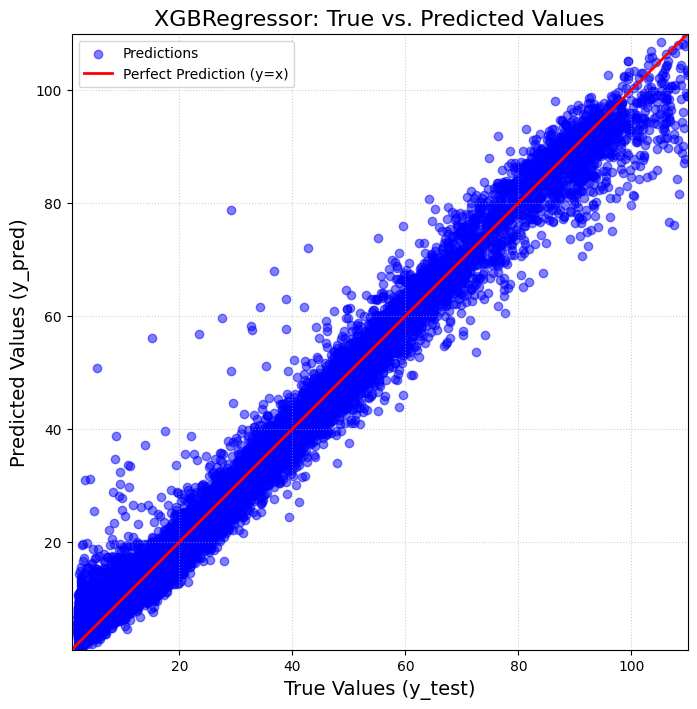

In [15]:
plot_predicted_true_graph(y_test, y_pred_xgb, "XGBRegressor: True vs. Predicted Values")

Explain the model using SHAP values

In [16]:
xgb_explainer = shap.Explainer(best_xgb_model)
shap_values = xgb_explainer(X_train)

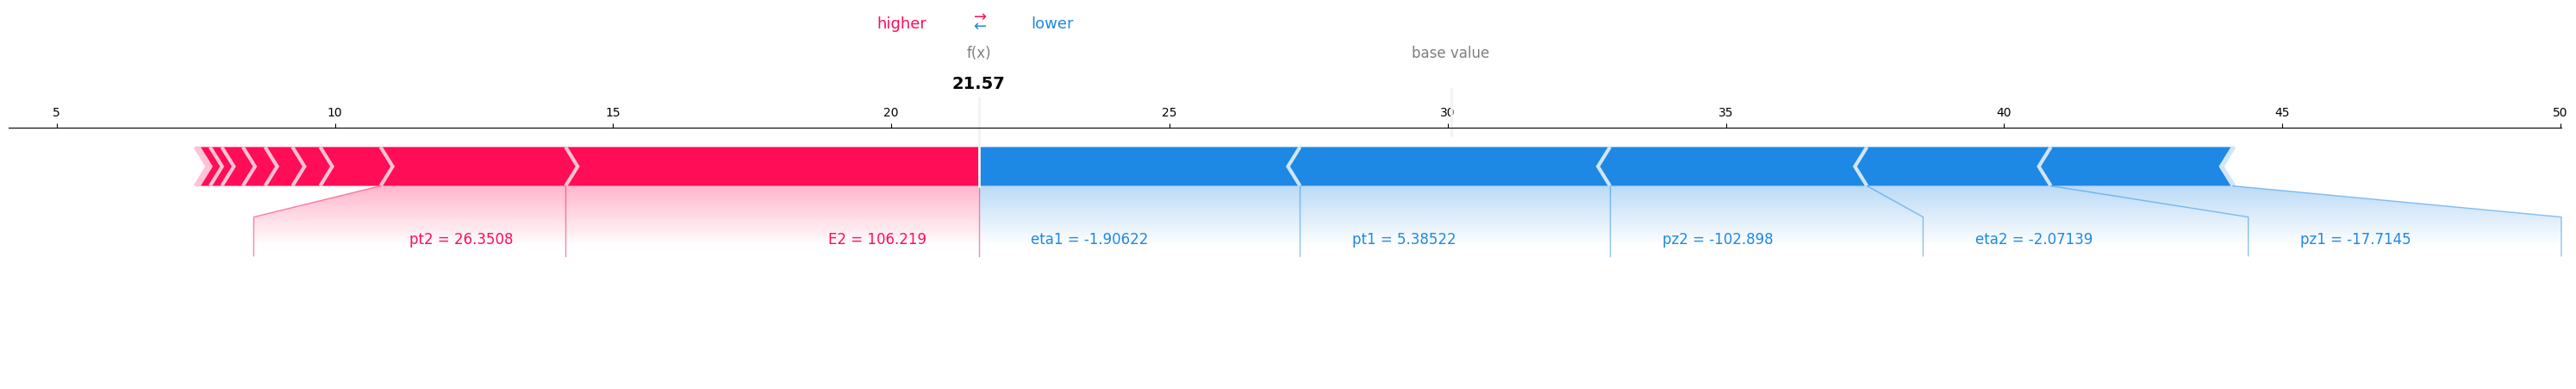

In [18]:
# visualize the first prediction's explanation with a force plot
shap.plots.force(shap_values[0], matplotlib=True, show=False)

# Make the plot larger
plt.gcf().set_size_inches(30, 5)
plt.tight_layout()
plt.show()

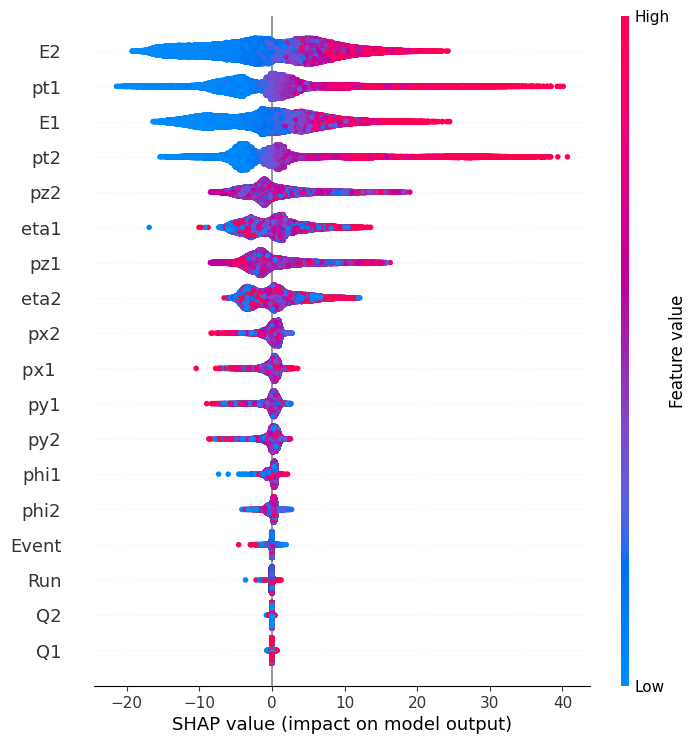

In [19]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=30)

2. Histogram-based Gradient Boosting Regression

In [20]:
from sklearn.ensemble import HistGradientBoostingRegressor

# The hyperparameter space
hgb_hyper_space = {
    'learning_rate': stats.uniform(0.01, 0.1),
    'max_iter': stats.randint(1000, 1200),
    'min_samples_leaf': stats.randint(15, 20),
    'max_depth': stats.randint(0, 20),
    'l2_regularization': stats.uniform(0, 0.1)
}

# Create the XGBoost model object
hgb_model = HistGradientBoostingRegressor()

# Do random search
best_hgb_model = random_search_tuning(hgb_model, hgb_hyper_space)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


c:\Users\User\Documents\Others\Random projects\random_stuffs\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
10 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\User\Documents\Others\Random projects\random_stuffs\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\User\Documents\Others\Random projects\random_stuffs\Lib\site-packages\sklearn\base.py", line 1358, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~

Best set of hyperparameters:  {'l2_regularization': np.float64(0.019622808931529956), 'learning_rate': np.float64(0.1008016098596329), 'max_depth': 15, 'max_iter': 1121, 'min_samples_leaf': 17}
Best score:  0.9918886075253528


In [21]:
# Train and evaluate
y_pred_hgb = train_and_test(best_hgb_model, "HistGradientBoostingRegressor")

HistGradientBoostingRegressor Performance:

R2 Score: 0.9924522702116623
MAE: 1.4590981165409358
MSE: 4.823659436586065


Plot the predicted and true values

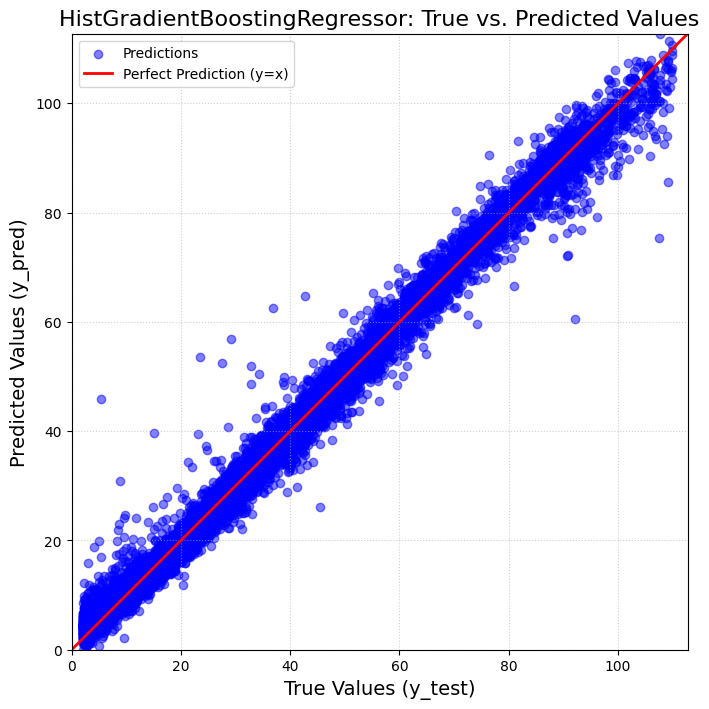

In [23]:
plot_predicted_true_graph(y_test, y_pred_hgb, "HistGradientBoostingRegressor: True vs. Predicted Values")

Explain the model using SHAP values

In [24]:
hgb_explainer = shap.Explainer(best_hgb_model)
shap_values = hgb_explainer(X_train)

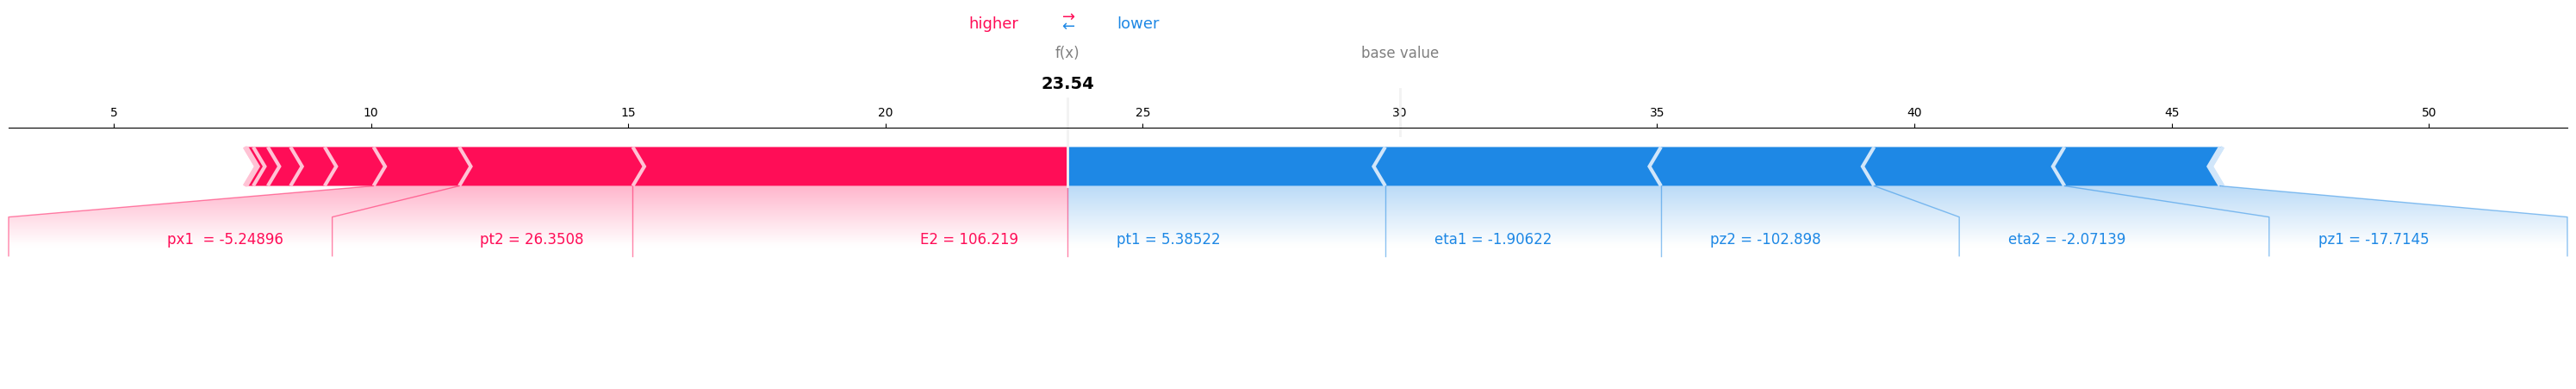

In [25]:
# visualize the first prediction's explanation with a force plot
shap.plots.force(shap_values[0], matplotlib=True, show=False)

# Make the plot larger
plt.gcf().set_size_inches(30, 5)
plt.tight_layout()
plt.show()

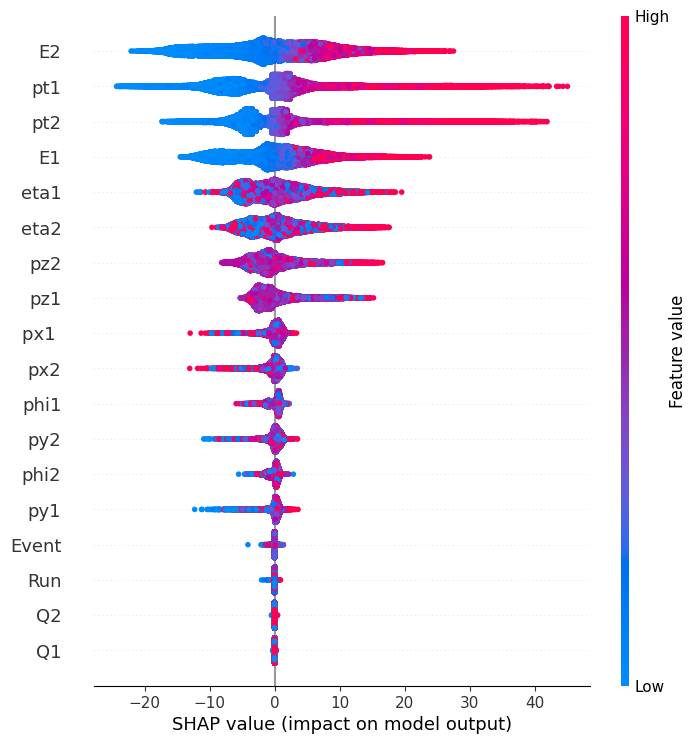

In [26]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=30)

3. Lightgbm

In [28]:
from lightgbm import LGBMRegressor

# The hyperparameter space (Similar to XGBRegressor)
lgbm_hyper_space = {
    'learning_rate': stats.uniform(0.01, 0.1),
    'n_estimators': stats.randint(50, 200),
    'max_depth': stats.randint(3, 10),
    'subsample': stats.uniform(0.5, 0.5),
    'reg_lambda': stats.randint(1, 10)
}

# Create the XGBoost model object
lgbm_model = LGBMRegressor()

# Do random search
best_lgbm_model = random_search_tuning(lgbm_model, lgbm_hyper_space)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best set of hyperparameters:  {'learning_rate': np.float64(0.08859462702590962), 'max_depth': 6, 'n_estimators': 199, 'reg_lambda': 5, 'subsample': np.float64(0.7269266425589432)}
Best score:  0.975073466401947


In [30]:
# Train and evaluate
y_pred_ = train_and_test(best_lgbm_model, "LGBMRegressor")

LGBMRegressor Performance:

R2 Score: 0.9750340628024331
MAE: 2.835614504530271
MSE: 15.955417315327804


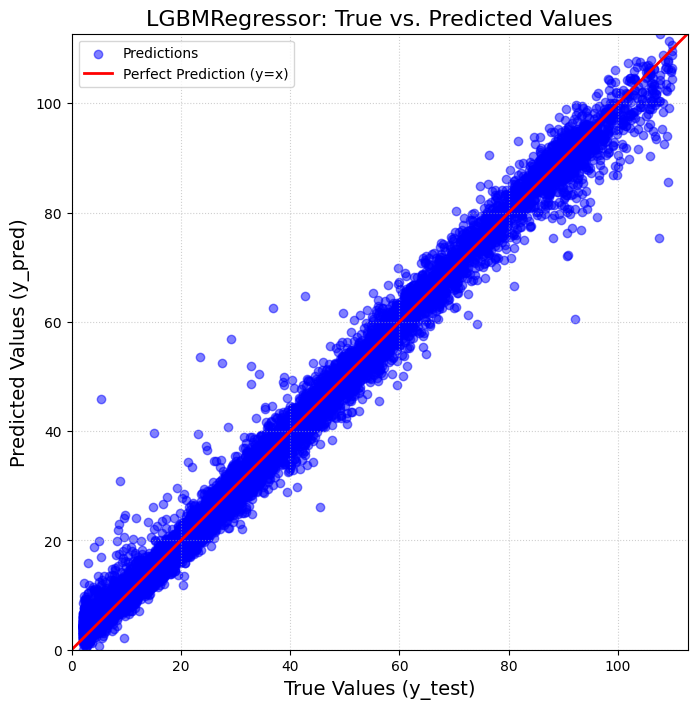

In [31]:
plot_predicted_true_graph(y_test, y_pred_hgb, "LGBMRegressor: True vs. Predicted Values")

Explain the model using SHAP values

In [32]:
lgbm_explainer = shap.Explainer(best_lgbm_model)
shap_values = lgbm_explainer(X_train)

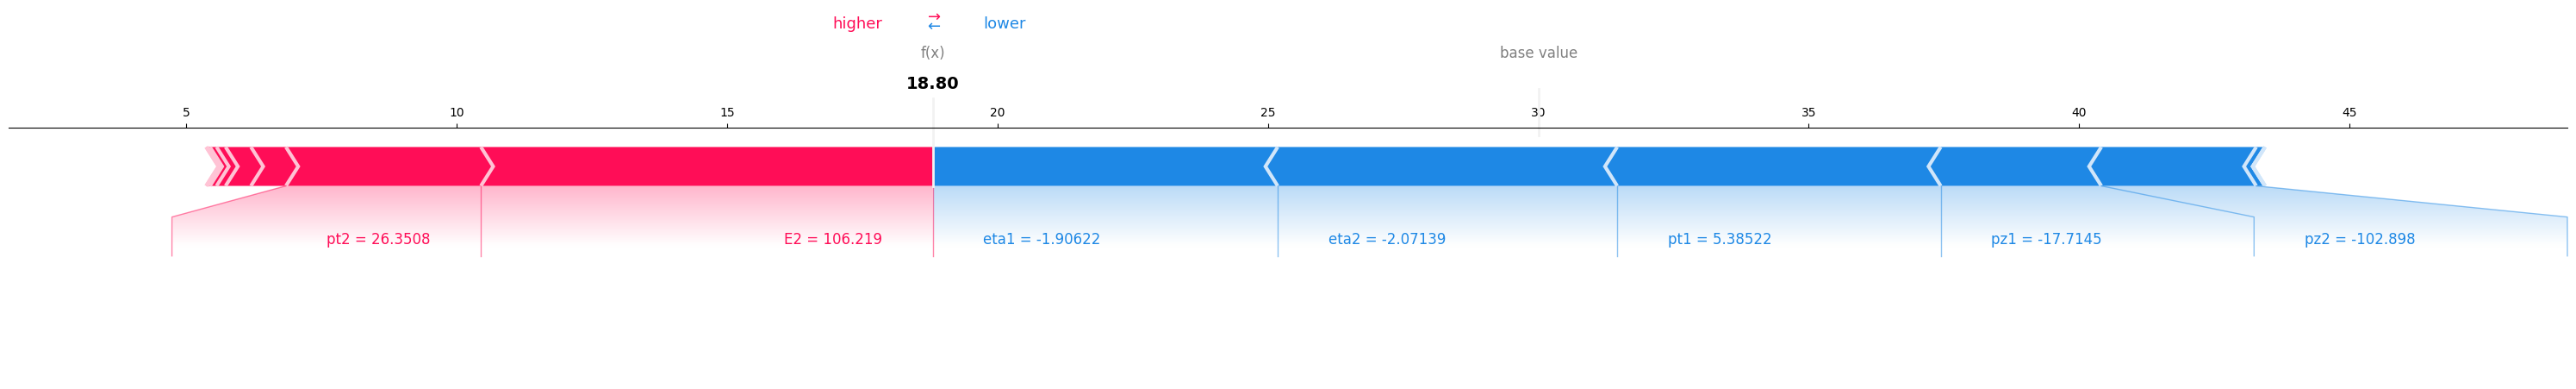

In [33]:
# visualize the first prediction's explanation with a force plot
shap.plots.force(shap_values[0], matplotlib=True, show=False)

# Make the plot larger
plt.gcf().set_size_inches(30, 5)
plt.tight_layout()
plt.show()

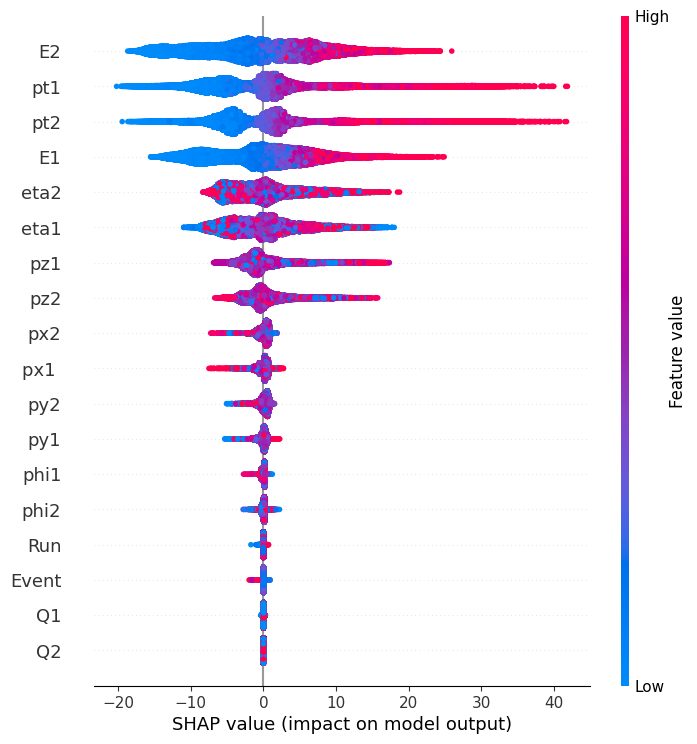

In [34]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=30)

## Comparison and Conclusion

The comparison table for the three models:

| Model                          | R^2 Score | MAE         | MSE         |
|:------------------------------:|:---------:|:-----------:|:-----------:|
| XGBRegressor                   | 0.98386329 | 2.12159256 | 10.31276805 |
| HistGradientBoostingRegressor  | 0.99245227 | 1.45909812 | 04.82365944 |
| LGBMRegressor                  | 0.97503406 | 2.83561450 | 15.95541732 |

HistGradientBoostingRegressor seems to be the best model for this task. XGBRegressor and LGBMRegressor fall behind by ~0.1 and ~0.2 R^2 score respectively.

The SHAP summary plot for this model shows the important features that the model focuses on.

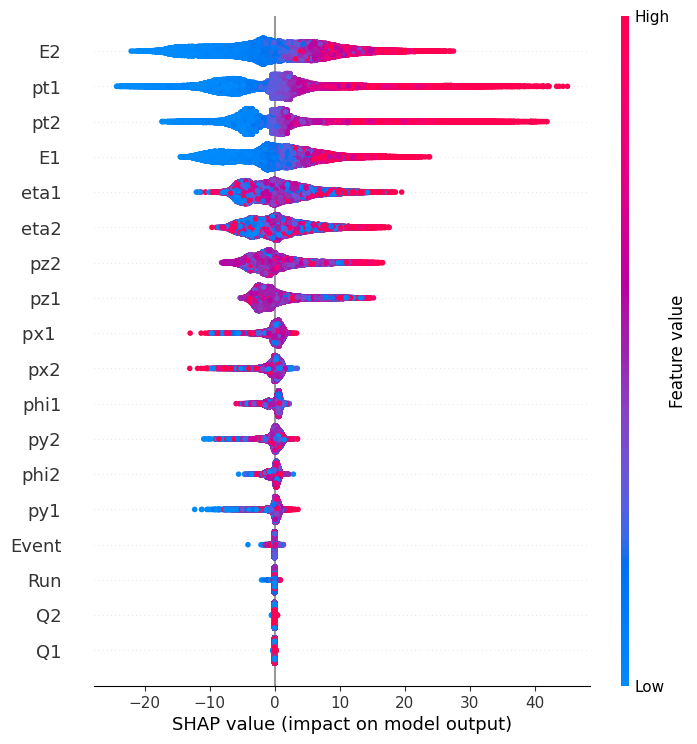

From all the summary plots it can be deduced that the invariance mass mostly depends on E1, E2 (the energy values) and pt1, pt2 (the transverse momentum values).